In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import io
import pandas as pd
import numpy as np
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Soft Computing/assignment3/Dataset 1.csv", encoding="ISO-8859-1")
print(len(df))
df.head()

10314


,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [ ]:
df['label'].unique()

array([0, 1])

In [ ]:
import re

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string


In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
puncset = list(string.punctuation)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def preprocess(text):
  sentence = [lemmatizer.lemmatize(i, pos='v') for i in text.split() if i not in puncset]
  sentence = [w for w in sentence if w.isalpha()]
  return ' '.join(sentence)

In [ ]:
df['message'] = df['message'].apply(remove_url)
df['message'] = df.message.map(lambda x: preprocess(x))

In [ ]:
df

,message,label
0,just have a real good i miss him so,0
1,be read manga,0
2,,0
3,Need to send to my accountant I even refer to ...,0
4,ADD ME ON,0
...,...,...
10309,No Depression by G Herbo be my mood from now d...,1
10310,What do you do when depression succumb the bra...,1
10311,Ketamine Nasal Spray Shows Promise Against Sui...,1
10312,dont mistake a bad day with everyone have,1


In [ ]:
df['Sentence_len'] = df['message'].apply(lambda x:len(str(x).split())) 
d = df['Sentence_len'] >0
df = df[d]

In [ ]:
df

,message,label,Sentence_len
0,just have a real good i miss him so,0,9
1,be read manga,0,3
3,Need to send to my accountant I even refer to ...,0,14
4,ADD ME ON,0,3
5,so good time tonight though,0,5
...,...,...,...
10308,Many sufferers of depression they feel nothing...,1,13
10309,No Depression by G Herbo be my mood from now d...,1,17
10310,What do you do when depression succumb the bra...,1,16
10311,Ketamine Nasal Spray Shows Promise Against Sui...,1,7


In [ ]:
max_sentence_length  = df['Sentence_len'].max()
print('Max Sentence Length: ',max_sentence_length)

Max Sentence Length:  57


In [ ]:
from collections import Counter

count = Counter()
for i in df.message:
  temp = i.split()
  for j in temp:
    count[j] += 1

In [ ]:
num_words = len(count)
print('num_words: ',num_words)

num_words:  12996


In [ ]:
from sklearn.model_selection import train_test_split
x = df['message']
y = df['label']

train_x,test_x,train_y,test_y = train_test_split(x, y, stratify=y,test_size=0.30,random_state=1)

In [ ]:
print("Train Samples = ",len(train_x))
print(train_y.value_counts())

print("Test Samples = ",len(test_x))
print(test_y.value_counts())

Train Samples =  7142
0    5534
1    1608
Name: label, dtype: int64
Test Samples =  3062
0    2372
1     690
Name: label, dtype: int64


In [ ]:
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#num_words = 12853

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(x)

In [ ]:
# Converting All Tweets to Tokens
x_train = tokenizer.texts_to_sequences(train_x.tolist()) 
x_test  = tokenizer.texts_to_sequences(test_x.tolist()) 

# Padding All Data
x_train = pad_sequences(x_train, padding='post', maxlen = max_sentence_length)
x_test  = pad_sequences(x_test,  padding='post', maxlen = max_sentence_length)

# Printing One Sentence
print(x_train[0])

[   3   45   83 1973   50   84 2253  713    6    6  182   10   48 2253
    2   22   59   10 1634  790    6  271  177  885  153   32  596  624
   51  153  384  216   19  233    5  764   53   18  112    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [ ]:
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses


lr = 0.001
max_features =20000
embedding_dim = 128
sequence_length = max_sentence_length

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(1000,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               
model.add(tf.keras.layers.Conv1D(500,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005))) 
model.add(tf.keras.layers.Conv1D(200,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005))) 

model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 57, 128)           2560128   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 1024)          394240    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 53, 512)           1573376   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 51, 256)           393472    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
              metrics=['TruePositives','TrueNegatives','FalsePositives','FalseNegatives','accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [ ]:
epochs = 5
batch = 128
history = model.fit(x_train, train_y, epochs=epochs, verbose=1,
                    batch_size=batch,
                    validation_data = (x_test,test_y))

Epoch 1/5
56/56 [==============================] - 148s 3s/step - loss: 1.0351 - true_positives: 10.0000 - true_negatives: 5515.0000 - false_positives: 19.0000 - false_negatives: 1598.0000 - accuracy: 0.7736 - precision: 0.3448 - recall: 0.0062 - val_loss: 0.5473 - val_true_positives: 19.0000 - val_true_negatives: 2372.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 671.0000 - val_accuracy: 0.7809 - val_precision: 1.0000 - val_recall: 0.0275
Epoch 2/5
56/56 [==============================] - 144s 3s/step - loss: 0.2847 - true_positives: 1161.0000 - true_negatives: 5455.0000 - false_positives: 79.0000 - false_negatives: 447.0000 - accuracy: 0.9264 - precision: 0.9363 - recall: 0.7220 - val_loss: 0.2469 - val_true_positives: 536.0000 - val_true_negatives: 2354.0000 - val_false_positives: 18.0000 - val_false_negatives: 154.0000 - val_accuracy: 0.9438 - val_precision: 0.9675 - val_recall: 0.7768
Epoch 3/5
56/56 [==============================] - 144s 3s/step - loss: 0.1586 - 

In [80]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sn

In [82]:
# accuracy: (tp + tn) / (p + n)
accuracy = history.history['accuracy']
accuracy_val = history.history['val_accuracy']

# precision tp / (tp + fp)
precision = history.history['precision']
precision_val = history.history['val_precision']

# recall: tp / (tp + fn)
recall = history.history['recall']
recall_val = history.history['val_recall']


loss = history.history['loss']
loss_val = history.history['val_loss']

# f1: 2 tp / (2 tp + fp + fn)
f1 = []
for p,r in zip(precision, recall):
  temp = 2 * ((p*r) + (p+r))
  f1.append(temp)
epoch = [x for x in range(epochs+1)]


f1_val = []
for p,r in zip(precision_val, recall_val):
  temp = 2 * ((p*r) + (p+r))
  f1_val.append(temp)

# confusion matrix
matrix = np.asmatrix([[history.history['true_positives'][-1],history.history['false_positives'][-1]],
         [history.history['false_negatives'][-1],history.history['true_negatives'][-1]]])
print(matrix)

[[1551.   19.]
 [  57. 5515.]]


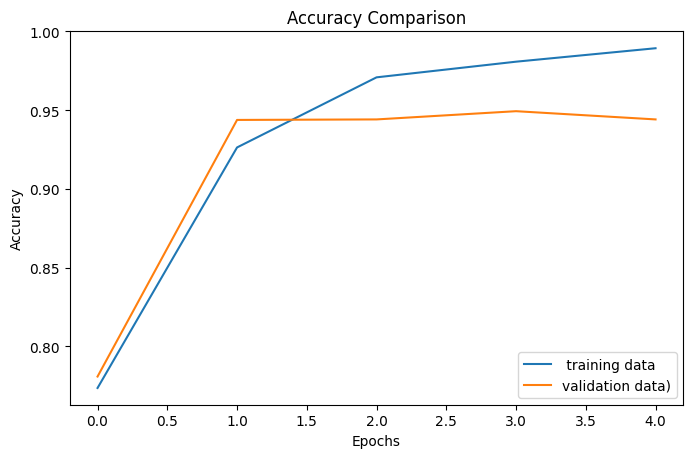

In [85]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['figure.dpi'] = 99
plt.plot(accuracy, label=' training data')
plt.plot(accuracy_val, label='validation data)')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc="lower right")
plt.show()


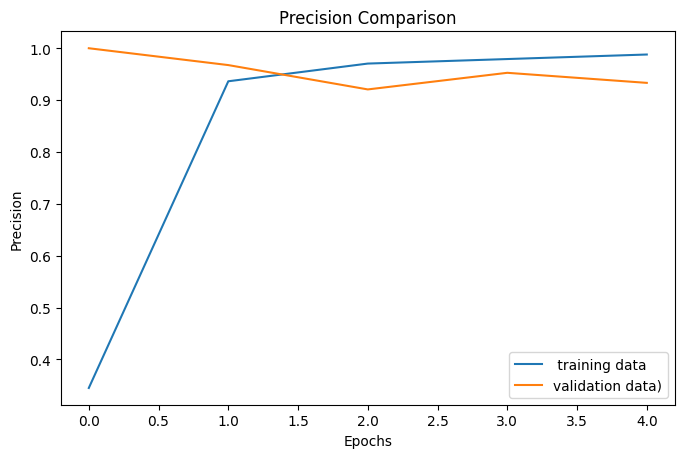

In [86]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['figure.dpi'] = 99
plt.plot(precision, label=' training data')
plt.plot(precision_val, label='validation data)')
plt.title('Precision Comparison')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.legend(loc="lower right")
plt.show()


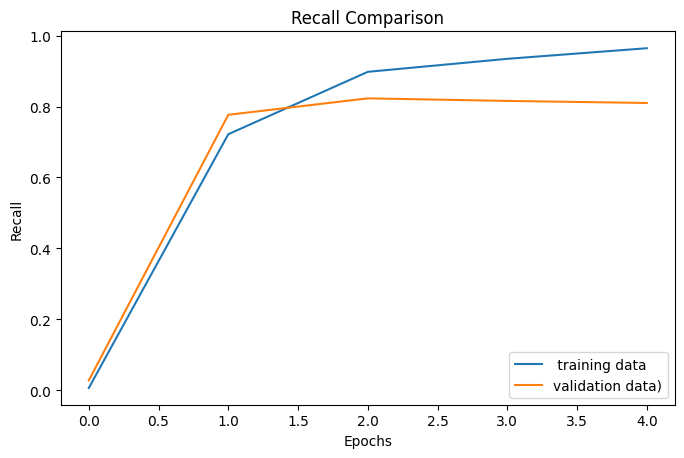

In [87]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['figure.dpi'] = 99
plt.plot(recall, label=' training data')
plt.plot(recall_val, label='validation data)')
plt.title('Recall Comparison')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.legend(loc="lower right")
plt.show()


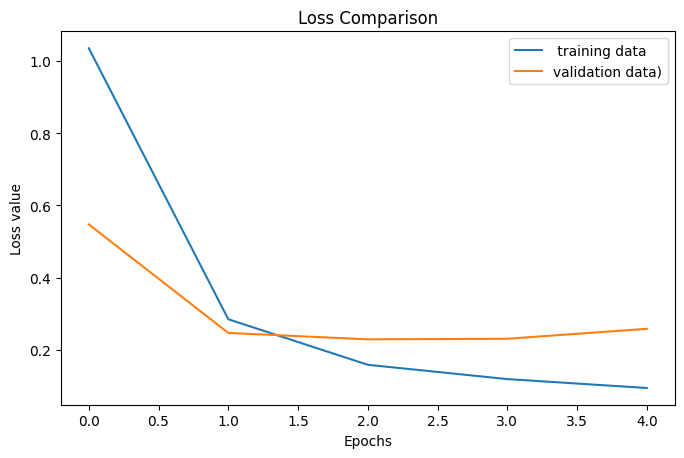

In [88]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['figure.dpi'] = 99
plt.plot(loss, label=' training data')
plt.plot(loss_val, label='validation data)')
plt.title('Loss Comparison')
plt.ylabel('Loss value')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

Text(0.5, 0, 'Epochs')

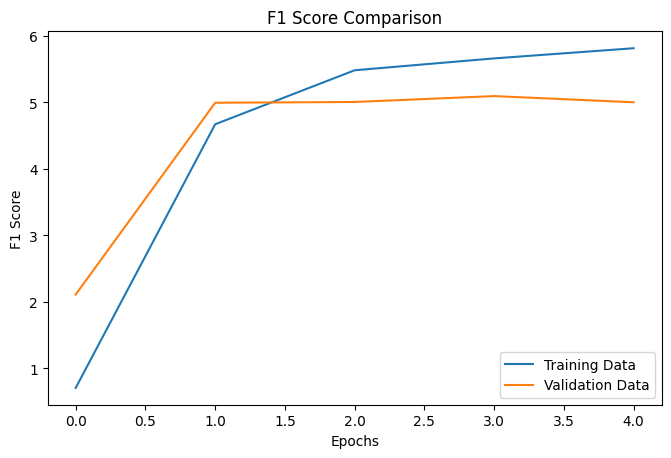

In [89]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['figure.dpi'] = 99
plt.plot(f1,label="Training Data")
plt.plot(f1_val,label="Validation Data")
plt.title('F1 Score Comparison')
plt.legend(loc="lower right")
plt.ylabel('F1 Score')
plt.xlabel('Epochs')

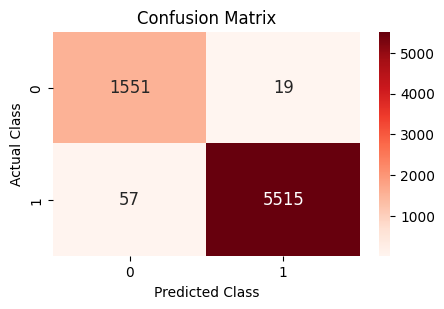

<Figure size 495x297 with 0 Axes>

In [90]:
plt.rcParams["figure.figsize"] = (5,3)

sn.heatmap(matrix, annot=True, annot_kws={"size": 12},cmap='Reds', fmt='g') 
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.savefig('Confusion_Matrix.png')
plt.show()
plt.savefig('cm.png')


In [56]:
def predict_sentiment(text):

  text = tokenizer.texts_to_sequences(text)
  test_vector = pad_sequences(
    text, maxlen = max_sentence_length, padding='post')
  
  predictions = model.predict(test_vector)
  prediction = list(predictions.flatten())
 
  if prediction[0] > 0.5:
    print(f'{prediction[0]:0.3}: Negative Sentiment')
    return 1
  else:
    print(f'{prediction[0]:0.3}: Positive Sentiment')
    return 0

In [72]:
test= ['suffer from chronic depression']

predict_sentiment(test)

1.0: Negative Sentiment


1

In [69]:
test= ['Excellent cast, story line, performances']

predict_sentiment(test)

0.00459: Positive Sentiment


0